# Markov-Snippets THUG on D-dimensional Ellipsoid

Basically same as experiment 74, except here we focus on a D-dimensional ellipsoid.

In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones
from numpy.linalg import solve, norm
from numpy.random import choice
from scipy.stats import multivariate_normal as MVN
import math
import time

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact

from Manifolds.GeneralizedEllipse import GeneralizedEllipse
from utils import prep_contour
from RWM import RWM
from tangential_hug_functions import HugTangential

In [2]:
p = 10
μ  = zeros(p)
Σ  = diag(np.r_[0.1, ones(p-1)])
level_set_value = -23
ellipse = GeneralizedEllipse(μ, Σ, exp(level_set_value))
πellipse = MVN(μ, Σ)
f = πellipse.logpdf
grad_f = lambda ξ: -solve(Σ, ξ - μ)

def generate_ηϵ(ϵ):
    """Generates ηϵ with a uniform kernel."""
    def ηϵ(x):
        if np.linalg.norm(f(x) - level_set_value) <= ϵ:
            return 1.0
        else: 
            return 0.0
    return ηϵ

def generate_logηϵ(ϵ):
    """As above, this is for the uniform kernel but this computes the log density."""
    def logηϵ(ξ):
        with np.errstate(divide='ignore'):
            return np.log(float(norm(f(ξ) - level_set_value) <= ϵ) / ϵ)
    return logηϵ

### Settings for THUG

In [3]:
def THUGIntegratorUnivariate(z0, B, δ, grad):
    """THUG Integrator for the 2D example (ie using gradients, not jacobians)."""
    trajectory = zeros((B + 1, len(z0)))
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    trajectory[0, :] = z0
    # Integrate
    for b in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
        trajectory[b+1, :] = np.hstack((x, v))
    return trajectory

def generate_THUGIntegratorUnivariate(B, δ):
    """Returns a THUG integrator for a given B and δ."""
    grad = lambda ξ: -solve(Σ, ξ - μ) #ellipse.Q(ξ).T.flatten()
    integrator = lambda z: THUGIntegratorUnivariate(z, B, δ, grad)
    return integrator


#### Metropolis-Hastings version for SMC version
def THUG_MH(z0, B, δ, logpi):
    """Similar to THUGIntegratoUnivariateOnlyEnd but this uses a MH step."""
    grad = lambda ξ: -solve(Σ, ξ - μ)
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    logu = np.log(np.random.rand())
    for _ in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
    if logu <= logpi(x) - logpi(x0):
        # accept new point
        return np.concatenate((x, v))
    else:
        # accept old point
        return z0

# Markov Snippets (v1)

In [4]:
class MarkovSnippetsTHUG:
    
    def __init__(self, N, B, δ, d, ϵs):
        """Markov Snippets SMC samplers corresponding exactly to Algorithm 1 in Christophe's notes.
        It uses the THUG kernel as its mutation kernel. The sequence of distributions is fixed here 
        since we provide ϵs, i.e. a list of tolerances which automatically fully specify the posterior 
        distributions used at each round.
        
        Parameters
        ----------
        
        :param N: Number of particles
        :type N:  int
        
        :param B: Number of bounces for the THUG integrator. Equivalent to `L` Leapfrog steps in HMC.
        :type B: int
        
        :param δ: Step-size used at each bounce, for the THUG integrator.
        :type δ: float
        
        :param d: Dimensionality of the `x` component of each particle, and equally dimensionality of 
                  `v` component of each particle. Therefore each particle has dimension `2d`.
        
        :param ϵs: Tolerances that fully specify the sequence of target filamentary distributions.
        :type ϵs: iterable
        """
        # Input variables
        self.N  = N       
        self.B  = B
        self.δ  = δ
        self.d  = d
        self.ϵs = ϵs       
        
        # Variables derived from the above
        self.P  = len(ϵs) - 1                                       # Number of target distributions
        self.ηs = [generate_ηϵ(ϵ) for ϵ in ϵs]                      # List of filamentary distributions 
        self.ψ = generate_THUGIntegratorUnivariate(B, δ)
    
    def initialize_particles(self):
        """Initialize by sampling with RWM on distribution with ϵ0."""
        # Initialize first position on the manifold
        x0 = ellipse.sample(advanced=True)
        # Generate log-density for self.η[0]
        logηϵ0 = generate_logηϵ(self.ϵs[0])
        # Sample using RWM
        burn_in = 100
        TO_BE_THINNED, _ = RWM(x0, self.δ, burn_in + 10*self.N, logηϵ0)
        # Thin the samples to obtain the particles
        initialized_particles = TO_BE_THINNED[burn_in:][::10]
        # Refresh velocities and form particles
        v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
        z0 = np.hstack((initialized_particles, v0))
        self.starting_particles = z0
        return z0
        
    def sample(self):
        """Starts the Markov Snippets sampler."""
        starting_time = time.time() 
        N = self.N
        B = self.B
        ## Storage
        #### Store z_n^{(i)}
        self.ZN  = np.zeros((self.P+1, N, 2*self.d))
        #### Store z_{n, k}^{(i)} so basically all the N(T+1) particles
        self.ZNK  = np.zeros((self.P, N*(B+1), 2*self.d))
        self.Wbar = np.zeros((self.P, N*(B+1)))
        self.ESS  = np.zeros((self.P))
        self.K_RESAMPLED = zeros((self.P, self.N))
        # Initialize particles
        z = self.initialize_particles()   # (N, 2d)
        self.ZN[0] = z
        # For each target distribution, run the following loop
        for n in range(1, self.P+1):
            # Compute trajectories
            Z = np.apply_along_axis(self.ψ, 1, z) # should have shape (N, B+1, 2d)
            self.ZNK[n-1] = Z.reshape(N*(B+1), 2*self.d)
            # Compute weights.
            #### Denominator: shared for each point in the same trajectory
            μnm1_z  = np.apply_along_axis(self.ηs[n-1], 1, Z[:, 0, :self.d])              # (N, )
            μnm1_z  = np.repeat(μnm1_z, self.B+1, axis=0).reshape(N, B+1) # (N, B+1)
            #### Numerator: different for each point on a trajectory.
            μn_ψk_z = np.apply_along_axis(self.ηs[n], 2, Z[:, :, :self.d])                         # (N, B+1)
            #### Put weights together
            W = μn_ψk_z / μnm1_z #np.exp(log_μn_ψk_z - log_μnm1_z)
            #### Normalize weights
            W = W / W.sum()
            # store weights (remember these are \bar{w})
            self.Wbar[n-1] = W.flatten()
            # compute ESS
            self.ESS[n-1] = 1 / np.sum(W**2)
            # Resample down to N particles
            resampling_indeces = choice(a=np.arange(N*(B+1)), size=N, p=W.flatten())
            unravelled_indeces = np.unravel_index(resampling_indeces, (N, B+1))
            self.K_RESAMPLED[n-1] = unravelled_indeces[1]
            indeces = np.dstack(unravelled_indeces).squeeze()
            z = np.vstack([Z[tuple(ix)] for ix in indeces])     # (N, 2d)
            
            # Rejuvenate velocities of N particles
            z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(N, self.d))
            self.ZN[n] = z
        self.total_time = time.time() - starting_time
        return z

In [32]:
# At this point, doesn't really matter which ϵs we use.
ϵs = np.geomspace(start=10, stop=0.001, num=20)
B = 20
δ = 0.1
N  = 5000
# Instantitate the algorithm
MSTHUG = MarkovSnippetsTHUG(N=N, B=B, δ=δ, d=p, ϵs=ϵs)

In [33]:
# Sample
zP = MSTHUG.sample()

# SMC (Metropolised version)

In [34]:
class MarkovSnippetsTHUGMetropolised:
    
    def __init__(self, N, B, δ, d, ϵs):
        """Metropolised version: for each particle compute the endpoint of trajectory and its weight.
        If the weight is positive, we accept the final point, otherwise we accept the initial point. 
        
        Parameters
        ----------
        
        :param N: Number of particles
        :type N:  int
        
        :param B: Number of bounces for the THUG integrator. Equivalent to `L` Leapfrog steps in HMC.
        :type B: int
        
        :param δ: Step-size used at each bounce, for the THUG integrator.
        :type δ: float
        
        :param d: Dimensionality of the `x` component of each particle, and equally dimensionality of 
                  `v` component of each particle. Therefore each particle has dimension `2d`.
        
        :param ϵs: Tolerances that fully specify the sequence of target filamentary distributions.
        :type ϵs: iterable
        """
        # Input variables
        self.N  = N       
        self.δ  = δ
        self.d  = d
        self.ϵs = ϵs       
        
        # Variables derived from the above
        self.P  = len(ϵs) - 1                                       # Number of target distributions
        self.ϖ  = MVN(zeros(d), eye(d))                             # Distribution of the velocities
        self.ηs = [generate_ηϵ(ϵ) for ϵ in ϵs]                      # List of filamentary distributions 
        
        self.B = B
    
    def initialize_particles(self):
        """To initialize particles, we sample from a uniform on a large rectangle.
        A rectangle of size [-100, 100] should be plenty large."""
        # Initialize particles by sampling from η_ϵ0 for a large ϵ0 which can be given as an argument.
        # Sample a point from the prior
        x0 = ellipse.sample(advanced=True) #np.random.uniform(low=-5, high=5, size=(self.d))
        # Use RWM starting from x0
        logηϵ0 = generate_logηϵ(self.ϵs[0])
        burn_in = 100
        TO_BE_THINNED, _ = RWM(x0, self.δ, burn_in + 10*self.N, logηϵ0)
        # Thin the samples to obtain the particles
        initialized_particles = TO_BE_THINNED[burn_in:][::10]
        v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
        z0 = np.hstack((initialized_particles, v0))
        self.starting_particles = z0
        return z0
        
    def sample(self):
        """Starts the Markov Snippets sampler."""
        starting_time = time.time()
        # Initialize particles
        z = self.initialize_particles()   # (N, 2d)
        # Storage
        self.PARTICLES    = zeros((self.P+1, self.N, 2*self.d))
        self.PARTICLES[0] = z
        self.WEIGHTS      = zeros((self.P+1, self.N))
        self.WEIGHTS[0]   = 1 / self.N
        self.ESS          = zeros(self.P+1)
        self.ESS[0]       = 1 / np.sum(self.WEIGHTS[0]**2)
        # For each target distribution, run the following loop
        for n in range(1, self.P+1):
            # Standard SMC sampler, we mutate the particles and then we resample
            ### Mutation step: 
            ###### Refresh velocities
            z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
            ###### Mutate positions 
            M = lambda z: THUG_MH(z, self.B, self.δ, self.ηs[n-1])
            Z = np.apply_along_axis(M, 1, z)
            ### Compute weights
            w = (abs(np.apply_along_axis(f, 1, Z[:, :p]) - level_set_value) <= self.ϵs[n]).astype(float)
            w = w / w.sum()
            self.WEIGHTS[n] = w
            self.ESS[n]     = 1 / np.sum(w**2)
            ### Resample
            indeces = choice(a=np.arange(self.N), size=self.N, p=w)
            z = z[indeces, :]
            self.PARTICLES[n] = z
        self.total_time = time.time() - starting_time
        return z

In [35]:
MSTHUG_METROP = MarkovSnippetsTHUGMetropolised(N=N, B=B, δ=δ, d=p, ϵs=ϵs)
zP_metrop = MSTHUG_METROP.sample()

# Time and Alive Particles

In [36]:
print("Markov Snippets: {:.2f}s".format(MSTHUG.total_time))
print("SMC-THUG       : {:.2f}s".format(MSTHUG_METROP.total_time))

Markov Snippets: 54.91s
SMC-THUG       : 33.71s


In [37]:
print("(Number of particles with non-zero weight for ϵ_P) / total sampling time: ")
print("MS  : {:.1f}".format(np.sum(MSTHUG.Wbar[-1] > 0) / MSTHUG.total_time))
print("SMC : {:.1f}".format(np.sum(MSTHUG_METROP.WEIGHTS[-1] > 0) / MSTHUG_METROP.total_time))

(Number of particles with non-zero weight for ϵ_P) / total sampling time: 
MS  : 412.1
SMC : 11.5


# Mean Functionals

In [38]:
# SMC-THUG: Mean Functional
def smc_mean(MS):
    W = MS.WEIGHTS[-1][..., None]
    Z = MS.PARTICLES[-1, :, :p]
    return np.sum(W*Z, axis=0)

# Markov-Snippets: Mean functional
def markov_snippets_mean(MS):
    W = MS.Wbar[-1].reshape(N, MS.B+1)[..., None] # (N, B+1, 1)
    Z = MS.ZNK[-1, :, :p].reshape(N, MS.B+1, p)   # (N, B+1, p)
    return np.sum(np.sum(W*Z, axis=1), axis=0)    # (2, )

In [39]:
print("Mean Functional")
print("MS  : {:.0e} {:.0e}".format(*markov_snippets_mean(MSTHUG)))
print("SMC : {:.0e} {:.0e}".format(*smc_mean(MSTHUG_METROP)))

Mean Functional
MS  : -2e-03 -5e-02
SMC : -5e-01 1e+00


# Effective Sample Size

In [40]:
print("ESS (final round)")
print("-----------------")
print("MS  : {:.1f}".format(MSTHUG.ESS[-1]))
print("SMC : {:.1f}".format(MSTHUG_METROP.ESS[-1]))

print("\n")

print("ESS/t (final round)")
print("-----------------")
print("MS  : {:.1f}".format(MSTHUG.ESS[-1] / MSTHUG.total_time))
print("SMC : {:.1f}".format(MSTHUG_METROP.ESS[-1] / MSTHUG_METROP.total_time))

ESS (final round)
-----------------
MS  : 22629.0
SMC : 386.0


ESS/t (final round)
-----------------
MS  : 412.1
SMC : 11.5


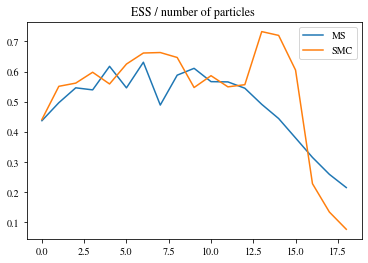

In [41]:
fig, ax = plt.subplots()
ax.plot(MSTHUG.ESS / (N*(B+1)), label='MS')
ax.plot(MSTHUG_METROP.ESS[1:] / N, label='SMC')
ax.legend()
ax.set_title("ESS / number of particles ")
plt.show()

In [42]:
def plot_histogram(n):
    fig, ax = plt.subplots(figsize=(20, 4))
    _, bins, _ = ax.hist(MSTHUG.K_RESAMPLED[n, :], density=True, bins=B, edgecolor='k', color='lightsalmon')
    ax.set_xticks(bins)
    ax.set_xticklabels(bins.astype(int))
    return plt.show()
    
interact(plot_histogram, n=(0, len(ϵs) - 2))

interactive(children=(IntSlider(value=9, description='n', max=18), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_histogram(n)>